In [155]:
import pandas as pd, wntr, matplotlib.pyplot as plt, copy, plotly

In [2]:
import matplotlib.pyplot as plt

In [41]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
plt.rcParams['figure.titlesize'] = 24

In [3]:
%matplotlib inline

In [4]:
import wntr

In [5]:
import copy

In [6]:
import plotly

In [7]:
#读取管径方案表
df = pd.read_excel('方案.xlsx',index_col=0)
#管径为0表示在该方案中无该管道

In [8]:
df

,现状,方案1,方案2,方案3
PIPE01,0,2000,2000,2200
PIPE02,0,1600,1600,1600
PIPE03,0,0,1600,1600
PIPE04,0,1600,0,1600


In [9]:
#现状管网模型
inp_file = 'K007.inp'

In [153]:
# 读取inp文件
wn = wntr.network.WaterNetworkModel('BASIC.INP') # 获取管网模型

In [14]:
# 改变管道启闭状态 (Opened, Closed, Active)
wn.links['PIPE03'].initial_status = 'Opened'

In [15]:
# 改变管道管径
wn.links['PIPE03'].diameter = 1.4

In [11]:
# 读取方案，生成模型
watermodel = {}
for i in df:
    watermodel[i] = copy.deepcopy(wn)
    for j in df[i].index:
        if df.loc[j, i] == 0:
            watermodel[i].links[j].initial_status = 'Closed'
        else:
            watermodel[i].links[j].diameter = df.loc[j, i]/1000
    #watermodel[i].write_inpfile(f'{i}.inp') # 输出模型为inp文件

In [12]:
watermodel

{'方案1': <wntr.network.model.WaterNetworkModel at 0x101035f0>,
 '方案2': <wntr.network.model.WaterNetworkModel at 0x1052ddf0>,
 '方案3': <wntr.network.model.WaterNetworkModel at 0x106c9df0>,
 '现状': <wntr.network.model.WaterNetworkModel at 0x101035b0>}

In [13]:
res = {}
# 模拟计算各个方案
for key, v in watermodel.items():
    res[key] = wntr.sim.EpanetSimulator(v).run_sim()
    #res[key].link.to_excel(f'{key}-link.xlsx') # 将结果按照方案输出为excel（管段数据）
    #res[key].node.to_excel(f'{key}-node.xlsx') # 将结果按照方案输出为excel（节点数据）

现状 <wntr.network.model.WaterNetworkModel object at 0x101035B0>
方案1 <wntr.network.model.WaterNetworkModel object at 0x101035F0>
方案2 <wntr.network.model.WaterNetworkModel object at 0x1052DDF0>
方案3 <wntr.network.model.WaterNetworkModel object at 0x106C9DF0>


In [14]:
# 计算结果可用参数列表
PARAMETERS = {'link':['flowrate', 'headloss', 'linkquality', 'status', 'velocity'],'node':['demand', 'head', 'pressure', 'quality']}

In [15]:
# 将结果保存为容易横向对比的数据结构
data = {}
for i, l in PARAMETERS.items():
    for key in l:
        temp = {}
        for index, value in res.items():
            if i == 'link':
                temp[index] = value.link[key]
            else:
                temp[index] = value.node[key]
        data[key] = pd.Panel(temp)
        del temp
        #data[key].to_excel(f'{key}.xlsx') # 将结果按照参数输出为excel

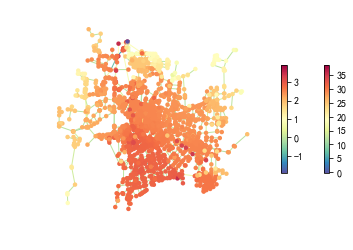

In [184]:
#管网压力图绘制
pressure_at_1hr = res['方案1'].node['pressure'].loc[25200,:]
flowrate_at_1hr = res['方案1'].link['flowrate'].loc[3600,:]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_1hr, 
                        link_attribute=flowrate_at_1hr)

plt.show()

In [178]:
df2 = pd.read_excel('报告设置.xlsx')

In [152]:
df2

,ID,参数
0,PIPE01,flowrate
1,PIPE01,velocity
2,PIPE02,flowrate
3,JGS009,pressure
4,PIPE01,headloss


In [62]:
#根据报告表生成图表
for i in df2.index:
    print(df2.loc[i,'ID'])
    data[df2.loc[i,'参数']][:,:,df2.loc[i,'ID']].plot(figsize=(8,5),title=f'{df2.loc[i,"ID"]}-{df2.loc[i,"参数"]}曲线图')
    plt.savefig(f'{df2.loc[i,"ID"]}-{df2.loc[i,"参数"]}曲线图')# 将曲线图保存为图片文件

PIPE01
PIPE01
PIPE02
JGS009


In [131]:
#根据报告生成报表
report = pd.DataFrame()
for i in df2.index:
    temp = data[df2.loc[i,'参数']][:,:,df2.loc[i,'ID']]
    temp['ID'] = df2.loc[i,'ID']
    temp['参数'] = df2.loc[i,'参数']
    report = report.append(temp)
report.set_index(['ID','参数',report.index], inplace=True)
report.sort_index(inplace=True)
report.to_excel('报告.xlsx')

In [128]:
report.sort_index().to_excel('报告2.xlsx')

In [185]:
wntr.graphics.network.plot_interactive_network(wn,figsize=[1200,800],node_attribute=pressure_at_1hr,node_range=[20,35])

In [21]:
plt.figure()

In [20]:
wntr.__version__

'0.1.5'

In [103]:
tt = data['flowrate'][:,:,'PIPE01']

In [104]:
tt['id'] = 'id'

In [105]:
tt

,方案1,方案2,方案3,现状,id
0,1.032755,1.073977,1.267838,0.0,id
3600,0.928433,0.961796,1.137806,0.0,id
7200,0.891745,0.922503,1.092688,0.0,id
10800,0.883708,0.913623,1.083912,0.0,id
14400,0.891964,0.918746,1.095826,0.0,id
18000,1.227000,1.281664,1.502442,0.0,id
21600,1.586845,1.666748,1.939753,0.0,id
25200,1.899799,1.983095,2.322531,0.0,id
28800,1.857696,1.935860,2.273500,0.0,id
32400,1.628663,1.708138,1.994991,0.0,id


In [98]:
t1 = data['flowrate'][:,:,'PIPE01']

In [99]:
t1.loc[:,'id'] = 'id2'

In [100]:
t2 = tt.append(t1)

In [102]:
t2.set_index(['id',t2.index]).to_excel('temp.xlsx')

In [165]:
data['pressure'][:,:,'Y007'].plot(figsize=(8,5),title='NODE01-pressure曲线图')

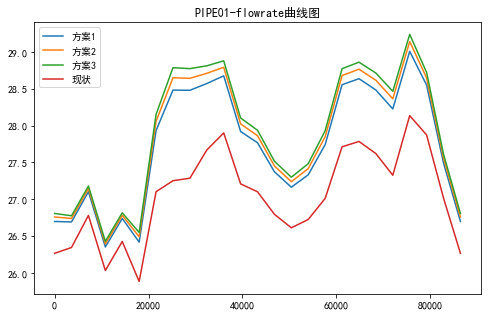

In [166]:
plt.show()

In [31]:
plt.savefig("temp.png")

In [181]:
df2[df2.参数.isin(PARAMETERS['node'])].ID

3    JGS009
5      Y007
6      Y099
7      Y029
Name: ID, dtype: object

In [175]:
'pressure' in PARAMETERS['node']

True

In [172]:
PARAMETERS['node']

['demand', 'head', 'pressure', 'quality']

In [182]:
data['pressure'][:,25200,df2[df2.参数.isin(PARAMETERS['node'])].ID]

,方案1,方案2,方案3,现状
name,,,,
JGS009,32.271469,32.236332,32.212513,32.465431
Y007,28.481464,28.648821,28.785479,27.251841
Y099,28.715569,28.981808,29.116289,27.747696
Y029,21.612076,21.903883,22.089075,20.652937


In [167]:
data['flowrate'][:,:,'PIPE01']

,方案1,方案2,方案3,现状
0,1.032755,1.073977,1.267838,0.0
3600,0.928433,0.961796,1.137806,0.0
7200,0.891745,0.922503,1.092688,0.0
10800,0.883708,0.913623,1.083912,0.0
14400,0.891964,0.918746,1.095826,0.0
18000,1.227000,1.281664,1.502442,0.0
21600,1.586845,1.666748,1.939753,0.0
25200,1.899799,1.983095,2.322531,0.0
28800,1.857696,1.935860,2.273500,0.0
32400,1.628663,1.708138,1.994991,0.0


In [44]:
df.plot?

In [136]:
x = data['flowrate'].to_xarray()

In [146]:
x.to_dataframe(name='xx')

xx
items major_axis minor_axis              
方案1   0          L1          2.155341e-01
                 L2          2.151160e-01
                 L4          1.754759e-01
                 L5         -8.212876e-02
                 L6          3.314988e-02
                 L7         -2.200902e-02
                 L8          9.222706e-02
                 L9          8.336286e-02
                 L11         3.061111e-03
                 L12        -4.350839e-03
                 L13        -2.578222e-02
                 L14         7.509690e-03
                 L15         5.051068e-02
                 L16         2.931773e-02
                 L15-86      6.530882e-03
                 L23         6.108750e-03
                 L24         1.347643e-02
                 L25        -4.208250e-03
                 L26        -7.672590e-03
                 L27        -1.424286e-02
                 L28         7.112844e-03
                 L29        -3.210802e-02
                 L30        -1.041733e-02
                 L31         9.888031e-03
                 L32         6.521430e-03
                 L33        -1.170708e-02
                 L34        -1.403655e-02
                 L35         1.134870e-03
                 L36         5.712360e-03
                 L38        -1.378596e-01
...                                   ...
现状    86400      L16-123     3.910463e-02
                 L16-124     3.910463e-02
                 L16-125     3.392957e-02
                 L16-126     7.303419e-02
                 L16-127     1.115931e-01
                 L16-128     1.129871e-01
                 L16-129     2.746601e-09
                 L16-130     2.651683e-01
                 L16-131     7.806925e-02
                 L16-132     1.870991e-01
                 L16-133     2.016176e-01
                 L16-134     2.016176e-01
                 L16-135     2.016176e-01
                 L16-110     2.690423e-01
                 L16-121     1.355795e-02
                 L16-136    -1.355795e-02
                 L16-138     3.236280e-03
                 Liu-lq-001  4.362462e-02
                 GD2         2.411775e-02
                 GD1        -7.107845e-01
                 GD3        -2.371973e-01
                 L241-1      2.576388e-01
                 L241-2      2.576388e-01
                 PIPE02      0.000000e+00
                 PIPE01      0.000000e+00
                 PIPE03      0.000000e+00
                 GD8         2.120400e-01
                 GD4         1.272240e-01
                 PIPE04      0.000000e+00
                 1           0.000000e+00

[296400 rows x 1 columns]

In [157]:
data['demand'].to_excel?

Object `to_excel` not found.


In [162]:
data['demand'].to_excel('temp.xlsx')

In [158]:
df.to_excel?